In [1]:
import pickle
from scipy.interpolate import interp1d
import numpy as np

from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import chi2

In [2]:
# dist = "gamma"
# n = 100
# file = open("data/data_gamma_n_100_mod_3_uid_8_28_2020_1_21.pkl",'rb')
# n = 1000
# file = open("data/data_gamma_n_1000_mod_3_uid_9_8_2020_16_11.pkl", 'rb')
# n = 10000
# file = open("data/data_gamma_n_10000_mod_3_uid_9_7_2020_15_16.pkl", 'rb')

dist = "gaussian"
n = 100
file = open("data/data_gaussian_n_100_mod_3_uid_8_30_2020_16_49.pkl", 'rb')
# n = 1000
# file = open("data/data_gaussian_n_1000_mod_3_uid_8_31_2020_13_7.pkl", 'rb')
# n = 10000
# file = open("data/data_gaussian_n_10000_mod_3_uid_9_7_2020_23_51.pkl", 'rb')

# dist = "uniform"
# n = 100
# file = open("data/data_uniform_n_100_mod_3_uid_8_30_2020_15_8.pkl", 'rb')
# n = 1000
# file = open("data/data_uniform_n_1000_mod_3_uid_9_2_2020_2_8.pkl", 'rb')
# n = 10000
# file = open("data/data_uniform_n_10000_mod_3_uid_9_7_2020_22_48.pkl", 'rb')

# dist = "chisq"
# n = 100
# file = open("data/data_chisq_n_100_mod_3_uid_8_30_2020_13_30.pkl", 'rb')
# n = 1000
# file = open("data/data_chisq_n_1000_mod_3_uid_9_3_2020_16_18.pkl", 'rb')
# n = 10000
# file = open("data/data_chisq_n_10000_mod_3_uid_9_7_2020_21_14.pkl", 'rb')

stuff = pickle.load(file, encoding='latin1')
file.close()

is_save = False

In [3]:
df = 3
coverage_1 = [] #at design points
coverage_2 = [] #sec 2.4 interpolation, at design points and extended points
coverage_3 = [] #linearly interpolated upper bound, at grid points
coverage_4 = [] #sec 2.4 iterpolation, at grid points.

ave_first_quartile_width = []
ave_median_width = []
ave_third_quartile_width = []

run_time = []

for repeat in range(1000):
    if not dist + str(repeat) + "_design_pts" in stuff:
        print("missing", repeat)
        continue
    design_pts = stuff[dist + str(repeat) + "_design_pts"]
    num_design_pts = len(design_pts)
    opt_pts = stuff[dist + str(repeat) + "_opt_design_pts"]
    # hi at design points
    hi_opt_pts = stuff[dist + str(repeat) + "_hi"]
    # lo at design points
    improved_lo_opt_pts = stuff[dist + str(repeat) + "_improved_lo"]
    extended_x = stuff[dist + str(repeat) + "_extended_x"]
    # hi at extended points
    improved_lo_extended_pts = stuff[dist + str(repeat) + "_extended_lo"]
    # lo at extended points
    improved_hi_extended_pts = stuff[dist + str(repeat) + "_extended_hi"]
    
    #################################################################################compute width
    first_sample_quartile = design_pts[num_design_pts // 4]
    sample_median = design_pts[num_design_pts // 2]
    third_sample_quartile = design_pts[int(num_design_pts // 4 * 3)]
    first_quartile_idx_in_opt_pts = np.argmin(np.abs(opt_pts - first_sample_quartile))
    median_idx_in_opt_pts = np.argmin(np.abs(opt_pts - sample_median))
    third_quartile_idx_in_opt_pts = np.argmin(np.abs(opt_pts - third_sample_quartile))
    #the bucket
    separate_point_12 = (opt_pts[first_quartile_idx_in_opt_pts] + opt_pts[median_idx_in_opt_pts]) / 2
    separate_point_23 = (opt_pts[third_quartile_idx_in_opt_pts] + opt_pts[median_idx_in_opt_pts]) / 2
    w1 = np.mean(hi_opt_pts[opt_pts <= separate_point_12] - improved_lo_opt_pts[opt_pts <= separate_point_12])
    w3 = np.mean(hi_opt_pts[opt_pts >= separate_point_23] - improved_lo_opt_pts[opt_pts >= separate_point_23])
    w2 = np.mean(hi_opt_pts[np.multiply(opt_pts >= separate_point_12, opt_pts <= separate_point_23)] 
                 - improved_lo_opt_pts[np.multiply(opt_pts >= separate_point_12, opt_pts <= separate_point_23)])
    ave_first_quartile_width.append(w1)
    ave_median_width.append(w2)
    ave_third_quartile_width.append(w3)
    
    ###############################################################################compute coverage
    x_grid = np.linspace(np.min(opt_pts), np.max(opt_pts), num=10000, endpoint=True)
    if dist == "uniform":
        f_opt_pts = 1.0/20 * np.ones(len(opt_pts))
        f_ext_pts = 1.0/20 * np.ones(len(extended_x))
        f_grid = 1.0/20 * np.ones(len(x_grid))
    elif dist == "gaussian":
        f_opt_pts = norm.pdf(opt_pts)
        f_ext_pts = norm.pdf(extended_x)
        f_grid = norm.pdf(x_grid)
    elif dist == "gamma":
        f_opt_pts = gamma.pdf(opt_pts, 1.0)
        f_ext_pts = gamma.pdf(extended_x, 1.0)
        f_grid = gamma.pdf(x_grid, 1.0)
    elif dist == "chisq":
        f_opt_pts = chi2.pdf(opt_pts, df)
        f_ext_pts = chi2.pdf(extended_x, df)
        f_grid = chi2.pdf(x_grid, df)
    else:
        print("distribution not supported")
        break
        
    if np.all(hi_opt_pts >= f_opt_pts) and np.all(improved_lo_opt_pts <= f_opt_pts):#design points
        coverage_1.append(1)
    else:
        coverage_1.append(0)
        
    if np.all(improved_hi_extended_pts >= f_ext_pts) and np.all(improved_lo_extended_pts <= f_ext_pts):#extended points
        coverage_2.append(1)
    else:
        coverage_2.append(0)
    
    l_log_func = interp1d(opt_pts, np.log(improved_lo_opt_pts))
    h_func = interp1d(opt_pts, hi_opt_pts)
    if np.all(h_func(x_grid) >= f_grid) and np.all(np.exp(l_log_func(x_grid)) <= f_grid):#linear upper bound; grid
        coverage_3.append(1)
    else:
        coverage_3.append(0)
        
    l_log_ext_func = interp1d(extended_x, np.log(improved_lo_extended_pts))
    h_log_ext_func = interp1d(extended_x, np.log(improved_hi_extended_pts))
    if np.all(np.exp(h_log_ext_func(x_grid)) >= f_grid) and np.all(np.exp(l_log_ext_func(x_grid)) <= f_grid):#M_i upper bound; grid
        coverage_4.append(1)
    else:
        coverage_4.append(0)
    
    run_time.append(stuff[dist + str(repeat) + "_run_time"])

## print results

In [4]:
print(sum(coverage_1), len(coverage_1))
print(sum(coverage_2), len(coverage_2))
print(sum(coverage_3), len(coverage_3))
print(sum(coverage_4), len(coverage_4))

963 1000
963 1000
963 1000
963 1000


In [5]:
covered_mask = np.array(coverage_3) == 1
ave_covered_first_quartile_width = np.array(ave_first_quartile_width)[covered_mask]
ave_covered_median_width = np.array(ave_median_width)[covered_mask]
ave_covered_third_quartile_width = np.array(ave_third_quartile_width)[covered_mask]
print(len(ave_covered_first_quartile_width))
print(np.mean(np.array(ave_covered_first_quartile_width)))
print(np.mean(np.array(ave_covered_median_width)))
print(np.mean(np.array(ave_covered_third_quartile_width)))

963
0.46374167988765386
0.6459004505473114
0.5216365063295841


In [6]:
print(np.mean(np.array(run_time)), np.var(np.array(run_time)))

5.660387966394424 0.18776176193331418


## save results

In [7]:
import csv
if is_save:
    with open("coverage_rates_band_widths_all_new2.csv", mode="a") as file_obj:
        csv_obj = csv.writer(file_obj, delimiter=",") # , quotechar='"', quoting=csv.QUOTE_MINIMAL
        csv_obj.writerow([dist, n, 
                          np.mean(np.array(coverage_1)), np.mean(np.array(coverage_2)),
                          np.mean(np.array(coverage_3)), np.mean(np.array(coverage_4)),
                          np.mean(np.array(run_time)),
                          np.mean(np.array(ave_covered_first_quartile_width)),
                          np.mean(np.array(ave_covered_median_width)),
                          np.mean(np.array(ave_covered_third_quartile_width))
                          ])
        file_obj.close()

## plots

In [8]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

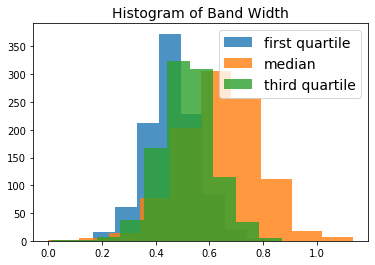

In [9]:
plt.hist(ave_first_quartile_width, label="first quartile", alpha=0.8)
plt.hist(ave_median_width, label="median", alpha=0.8)
plt.hist(ave_third_quartile_width, label="third quartile", alpha=0.8)
plt.title("Histogram of Band Width", fontsize=14)
plt.legend(fontsize=14)

Text(0.5, 1.0, 'Histogram of Run Time')

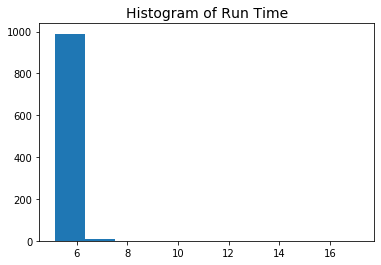

In [10]:
plt.hist(run_time)
plt.title("Histogram of Run Time", fontsize=14)